---
# Homework 2 - eCommerce analytics
---

# Notes before starting

We dealt with a huge amount of data from the files `2019-Oct.csv` and `2019-Nov.csv`. These files have a total size equal to 13.4GB. For all the questions, we reduced the amount of RAM required by loading only the needed columns and, since some columns data allows it, we forced some data casting to data types smaller in size. Specifically, for example, we loaded the `user_id` values as `numpy.int32` instead of default `numpy.int64`, since we observed that `user_id` values are of 10<sup>8</sup> order.

Moreover, we tried to handle these data applying two different strategies. The first one was executing the functions in Google Colab. According to the second one, we implemented some functions chunking the dataset, computing by chunk and then combining the results. We are aware that this implementation adds a lot of overhead, but this way we managed to run these functions on a laptop with only 8GB of RAM. In addition, we had the opportunity to learn how to work with chunks. For this sake, we decided to keep these functions inside the main script file `./scripts/our_functions`. All the questions marked with a **\*** were solved with such functions.

# Setup

As previously mentioned, in order to keep the notebook tidy, for each question, we put the functions in the file `./scripts/our_functions.py`.

In [1]:
import scripts.our_functions as f

Specifically, the libraries we used are the following:

```python
# for data handling and analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import datetime

# utilies for computational performance evaluation and debugging
from tqdm import tqdm
from threading import Thread
from queue import Queue
import os, glob
```

To have an insight into the data handling, we show the routine function to load the needed data for each question (only for the questions marked with an asterisk): 

```python
def get_needed_iterator(month_files:list, columns:list, chunksize:int=10**6, parse_dates=False):
    global DATA_PATH, dtype
    iterators = []
    date_parser = pd.to_datetime if parse_dates else None
    for month in month_files:
        iterators.append(pd.read_csv(os.path.join(DATA_PATH, month), usecols=columns, 
                                     parse_dates=parse_dates, date_parser=date_parser, 
                                     chunksize=chunksize, dtype=dtype))
    return iterators
```

According to the pandas API, we split the dataset into chunks of 10<sup>6</sup> rows and we obtain an iterator. Using this iterator properly, we get all the data required for each question.

---
# [RQ1]  Which is the rate of complete funnels? *

According to the question statement, a complete funnel involves three steps: 1) view, 2) cart and 3) purchase. Because an event of type *cart* implies (and corresponds to) an event of type *view*, we only select the rows related to a *cart* and *purchase* events. Then, regarding to the *purchase* event, we make a distinction between the purchases after a corresponding *cart* event and the one-click purchases, which don't correspond to a *cart* event. Besides the complete funnels, we consider incomplete funnels the route {1} (orphan views) and the route {1,2} (orphan carts).

To be clear, the sets that we consider in order to compute the rate of complete funnels are:

$
U = \{\text{all tuples}\}\\
P = \{\text{purchase tuples}\}\\
C = \{\text{cart tuples}\}
$

The set $P - (P \cap C)$ contains only the one-click purchases. So, given the cardinalities

$
|U| = n_{tuples}\\
|P| = n_{purchases}\\
|C| = n_{carts}\\
|P-(P \cap C)| = n_{one-click}
$

we compute the rate of complete funnels without one-click purchases as

$
r_{\%}=\frac{n_{purchases}-n_{one-click}}{n_{tuples}-2\dot(n_{purchases}-n_{one-click})-[n_{carts}-(n_{purchases}-n_{one-click})]-n_{one-click}} = \frac{n_{purchases}-n_{one-click}}{n_{tuples}-n_{purchases}-n_{carts}}
$

Similarly, we compute the rate of complete funnels with one-click purchases.

We show two results, one that corresponds only to the route {1,2,3} and the other that takes into account also the route {1,3} (one-click purchases).

In [5]:
f.complete_funnels(['event_type', 'user_session', 'product_id'])

There are 1659788 purchases,
of which 556992 one_click purchases (only view-purchase couples).
The number of carts is 3955446.


Rate of complete funnels without one_click purchases:	1.06%.

Rate of complete funnels with one_click purchases:	1.59%.


The results show that the **1.06%** of the funnels, excluding the view-purchase ones, are complete. The interesting outcome is that the rate of complete funnels increases of about 50% if taking into account also the one-click purchases (**1.59%**). We deduce that customers often enjoy the one-click route instead of the "traditional" route, maybe thanks to the immediacy of the transaction. 

## What’s the operation users repeat more on average within a session? *

In order to get, for each session and event (*view*, *cart*, *purchase*), the average number of operations performed by users, we need to count the tuples of each event and the number of distinct sessions; then, the rate $\frac{n_{event}}{n_{sessions}}$ is the requested outcome.

4.53 views, 0.17 carts, 0.07 purchases. 23,016,651 sessions.




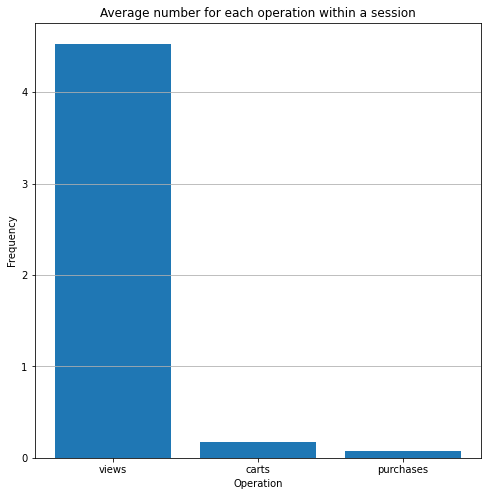

In [6]:
f.average_number_operations(['user_session', 'event_type'])

Observing the plot, it is evident that the number of *views* is far way greater than the number of *carts* and *purchases*; specifically, it is more than 26 and 64 times greater, respectively. This outcome, as expected, confirms the result discussed in the previous sub-point: customers view a lot of products, maybe many times each, before deciding to add them to the cart and making a purchase.

## How many times, on average, a user views a product before adding it to the cart? *

To solve this task, the needed attributes are `user_id`, `product_id`, `event_type` and `event_time`. Selecting the sets related to *cart* and *view* events and joining them on `user_id` and `product_id` give the desired result. It is relevant to remark that the attribute `event_time` is crucial to filter the tuples of the joint set according to the condition `event_time_view < event_time_cart` for each `(user_id, product_id)` couple. 

In [3]:
f.average_views_before_cart(['user_id', 'product_id', 'event_type', 'event_time'])

On average a user views a product 10.05 times before adding it to the cart.


As expected by analyzing the plot above, a user views a product **10 times** before adding it to the cart. This is the reason why the *view* event overcomes the others by far.

## What’s the probability that products added once to the cart are effectively bought? *

Let $C$ and $P$ be the events such that

$
C = \{\text{a product is added to the cart}\}\\
P = \{\text{a product is bought}\}.
$

In this task, we are asked to find the probability that products added once to the cart are effectively bought, that is the conditional probability $\mathbb{P}(P|C)$. According to the definition of conditional probability, we have

$
\mathbb{P}(P|C)=\frac{\mathbb{P}(C\cap P)}{\mathbb{P}(C)}.
$

The probability of the event C is

$
\mathbb{P}(C)=\frac{\text{# of cart tuples}}{\text{# of tuples}}=\frac{n_{cart}}{n_{tuples}}.
$

Similarly, the probability of the event $C\cap P$ is

$
\mathbb{P}(C\cap P)=\frac{\text{# of cart tuples corresponding to purchase tuples}}{\text{# of tuples}}=\frac{n_{cart\_purchase}}{n_{tuples}}.
$

Then, the requested probability is $\mathbb{P}(P|C)=\frac{n_{cart\_purchase}}{n_{tuples}}\times\frac{n_{tuples}}{n_{cart}}=\frac{n_{cart\_purchase}}{n_{cart}}$.

In [4]:
f.probability_purchase(['user_session', 'product_id', 'event_type'])

The probability that products added once to the cart are effectively bought is 0.28%.


As the result points out, more than **1 addition to the cart in 3** is successful. Once again, this result visually finds confirmation in the plot above.

## What’s the average time an item stays in the cart before being removed? *

For this task, we came up with an estimation of the average time an item stays in the cart before being removed. Indeed, despite the [description of the data](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Oct.csv) and according to [this punctualization](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store/discussion/132470#757896), there is no *removefromcart* event. Then, observing the behaviour of some famous e-commerce stores, we assumed that the cart state lives within a session; this means that when the session expires, the cart is deleted. In other words, the cart state is session-bound. 

To approximate the session expiration, we pick the last operation within each session, that is the operation with the maximum timestamp within the session. Performing the timestamp difference between a cart event and the corresponding last session operation, we are able to compute the desired average time.

In [4]:
f.average_time_cart(['event_type', 'user_session', 'product_id', 'event_time'])

On average, an item stays in the cart 454.93 minutes before being removed.


On average, an item stays in the cart about **8 minutes** (454.93 seconds) before being removed.

## How much time passes on average between the first view time and a purchase/addition to cart? *

Because the question is pretty generic, we decided to analyze two different cases in order to highlight some characteristics of the customers.

The first case we dealt with is considering the average time between the very first view of a user and her very first addition to the cart/purchase. In other words, we chose to measure how much time a user takes before generating a profit.

In [5]:
f.average_time_after_first_view_1(['event_type', 'event_time', 'user_id'])

The average time between the first view time and a purchase/addition to cart is 257.77 hours.
The standard deviation is 357.54 hours.


To be more aware of the amount of time, we convert the result into days:

In [6]:
print(f'The average time between the first view time and a purchase/addition to cart is {round(257.77 / 24)} days.')
print(f'The standard deviation is {round(357.54 / 24)} days.')

The average time between the first view time and a purchase/addition to cart is 11 days.
The standard deviation is 15 days.


On average, a user generates a profit **11 days** after she learnt about our business, which is pretty much! The standard deviation of **15 days** points out that there are some outliers in the delta-time distribution: probably, there are some users who view and add/buy a product immediately and others that add/buy a product after many weeks.

In the second case we analyzed, we consider the average time between the very first view of a specific product by a user and its corresponding addition to the cart/purchase. To be clear, we estimate how much time a user takes before deciding to buy a specific product she previuosly saw. We filter the tuples by the attribute `user_id` instead of `user_session` because a user may view a product for the first time during one session and add it to the cart/purchase it during another session. 

In [7]:
f.average_time_after_first_view_2(['event_type', 'event_time', 'user_id', 'product_id'])

The average time between the first view time and a purchase/addition to cart is 2858.08 minutes.


Even in this case, we convert the result into a more meaningful time unit:

In [8]:
print(f'The average time between the first view time and a purchase/addition to cart is {round(2858.08 / 60)} hours.')

The average time between the first view time and a purchase/addition to cart is 48 hours.


On average, a user decides to buy a specific product after about **48** hours.

# [RQ2]  What are the categories of the most trending products overall?

We produced a plot showing the number of sold products per category: obtaining a subset of only the purchases, we grouped by category code, and counted the number of sold product plotting the biggest 10 values

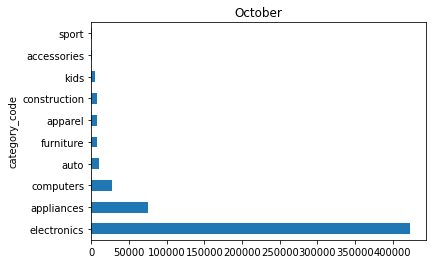

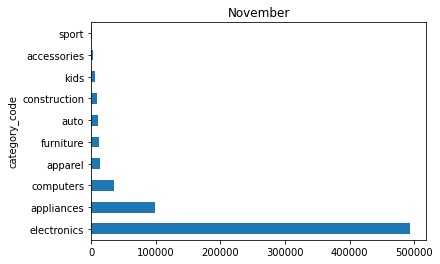

In [3]:
f.num_sold_per_cat()

We then plotted the 10 most visited subcategories, obtaining a subset of only the views, grouping by category code and counting the views of each category

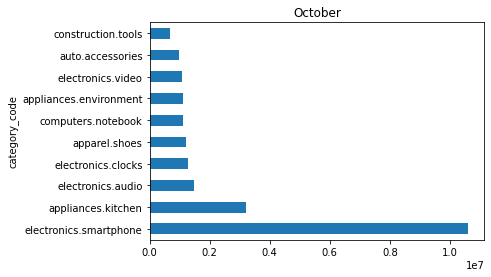

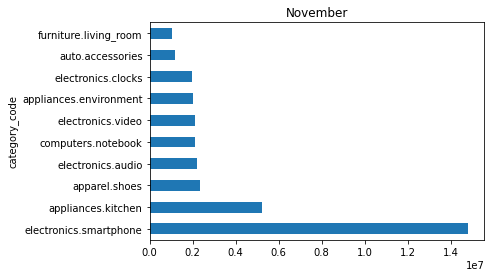

In [ ]:
f.most_v_cat()

And eventually we produced a list showing the most sold products per category: obtaining a subset of only the purchases, we counted, for each category code, the number of sold products

In [ ]:
f.most_sold_per_cat()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


accessories
product_id
18300155    105
18300021     87
28401112     56
18300460     51
28400759     50
18300141     42
18300214     39
52900016     38
18300370     33
28400912     31
Name: event_type, dtype: int64
apparel
product_id
28720716    101
54900013    100
54900004     97
28718083     93
28716978     91
54900011     89
28716666     85
28719606     83
28719635     74
54900012     71
Name: event_type, dtype: int64
appliances
product_id
3700926    3439
3600661    3224
3600666    2008
3601405    1908
3600163    1896
3700766    1384
2900958    1235
3601485    1189
3701134    1167
2702277    1100
Name: event_type, dtype: int64
auto
product_id
6000094    1885
4700478     894
6000227     849
5701128     628
5701166     578
6000004     480
6000229     467
4700630     452
4700589     397
5701002     341
Name: event_type, dtype: int64
computers
product_id
1307310    2332
1307073    1604
1307188    1207
1307067    1189
1306650     924
1307545     908
1307366     763
1307187     744
1307004

# [RQ3] For each category, what’s the brand whose prices are higher on average?

As a result of the analysis, what appears to be a constant trend throughout the answers, is that the most expensive brands, and associated products as well, are by far the ones of electronics devices and electronic domestic appliances; the only exception consists of sport bycicles outpricing the others. To have a general overview of the average price by brand for each category we implemented this function, it is easy to observe the brands whose prices are higher on average.

In [ ]:
f.avg_price_by_brand()

category_code  brand        
sport          pinarello        2533.238525
               nordictrack      2522.590088
               kessler          2372.000000
appliances     climadiff        2261.951172
computers      dreammachines    2221.466309
construction   helix            2199.047852
electronics    rado             2062.926025
furniture      senspa           1976.539551
               trevi            1959.888672
electronics    louiserard       1931.751465
Name: price, dtype: float32 





## Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand

The function we implemented is quite similar to the one called above, except for the fact that the user is asked to indicate a precise category.



```python
def avg_price_by_brand_cat():
    global DATA_PATH
    cols = ['category_code', 'brand', 'price']
    ds10 = pd.read_csv(DATA_PATH + "2019-Oct.csv", dtype={'price':np.float32}, usecols=cols)
    ds11 = pd.read_csv(DATA_PATH + "2019-Nov.csv", dtype={'price':np.float32}, usecols=cols)
    dstot = pd.concat([ds10, ds11]).dropna()

    extract_cat = lambda x: x.split('.')[0]
    dstot.category_code = dstot.category_code.map(extract_cat)

    print("Enter the category_code whose average price by brand you want to know")
    cat = input()
    dstot_grouped1 = dstot[dstot["category_code"]==cat].groupby("brand")["price"].mean()
    dstot_grouped1.plot.bar(figsize=(50, 20))
    plt.show()
    
    return
```

If we consider for example the category_code "electronics", the brand Rado turns out to have higher prices compared to the others.

Enter the category_code whose average price by brand you want to know
electronics


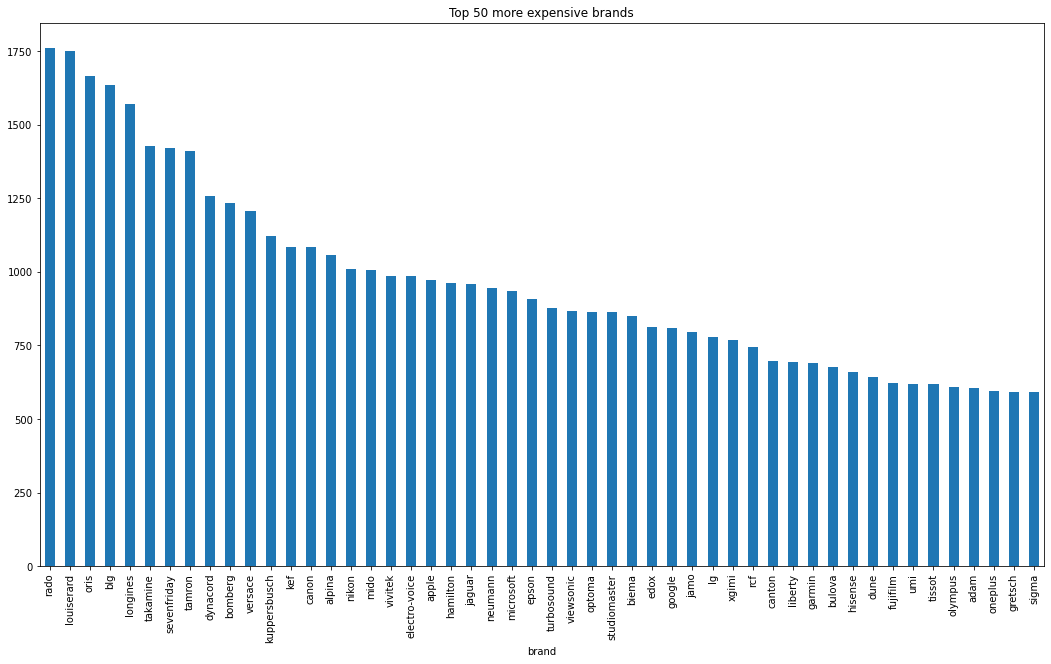

In [ ]:
f.avg_price_by_brand_cat()

## Find, for each category, the brand with the highest average price. Return all the results in ascending order by price

Apart from some modifications, the code is resemblant to the ones above. The considerations made at the beginning of Question 3 refer particularly to this sub-question.

In [3]:
f.highest_avg_price_brand()

     category_code          brand        price
2327      medicine          omron    97.573456
2480    stationery             hp   154.561722
110    accessories        weekend   550.849976
1260  country_yard         viking   712.080383
788           auto         remeza   863.195679
266        apparel    sergiorossi  1030.058350
505     appliances           jura  1686.643555
1569   electronics           rado  1758.832275
2063          kids         hartan  1801.819946
1896     furniture         senspa  1930.541992
1096  construction          helix  2033.526245
867      computers  dreammachines  2187.494873
2422         sport    nordictrack  2522.590088


# [RQ4] How much does each brand earn per month? *

As we were asked, we wrote the following function to get the profit per month given the brand name:

```python
def get_profit_per_month(brand_name, dataset_list:list=None):
    global month_files
    if dataset_list == None:
        dataset_list = get_purchases(['brand', 'product_id', 'price', 'event_type'])
    profit_per_month = {}
    for i in range(len(month_files)):
        profit = 0
        month_name = month_files[i][5:8]
        brand_items = dataset_list[i][dataset_list[i].brand == brand_name]
        if not brand_items.empty:
            profit = brand_items[(brand_items.price.notna()) & 
                                 (brand_items.price.notnull())].price.agg('sum')
        profit_per_month[month_name] = profit
    return profit_per_month
```

The profit of a brand is equal to the sum of the purchases of the brand products. So, we get the *purchase* tuples and we filter on the brand name. This way, the function returns a dictionary containing (month->profit) couples. 

For example, the profit of the brand Samsung is:

In [ ]:
profit = f.get_profit_per_month('samsung')
print(f'Samsung earned {profit["Oct"]:,.2f}$ in October and {profit["Nov"]:,.2f}$ in November.')

Samsung earned 46,407,524.00$ in October and 54,869,880.00$ in November.


## Is the average price of products of different brands significantly different? *

To answer to this question, we first compute the mean of the price of the distinct products for each brand; then, we calculate the standard deviation of the means. Indeed, the standard deviation allows us to understand how much the average price of each brand differ from the mean.

In [ ]:
brand_means = f.price_std_dev(['brand', 'product_id', 'price'])

The mean of the average price of the products for each brand is 171.71$,
with a standard deviation of 267.11$.


Comparing the mean we obtained with the related standard deviation, we can deduce that the variation inside the average price distribution is pretty relevant. To prove this, we can take the maximum and the minimum average price:

In [ ]:
print(f'The minimum average price is:\t{brand_means.min():,.2f}$.\nThe maximum average price is:\t{brand_means.max():,.2f}$.')

The minimum average price is:	0.97$.
The maximum average price is:	2,522.59$.


As shown, there is a huge difference between the maximum and the minimum average price.

## Find the top 3 brands that have suffered the biggest losses in earnings between one month and the next *

We assumed as "biggest losses" the percentage losses between one month and the next. We compute the loss as:

$
l_{\%} = \frac{profit_{nov}-profit_{oct}}{profit_{oct}+1}\times 100
$

We add 1 to $profit_{oct}$ to avoid zero divisions. This implies that, when $profit_{nov}$ is 0, the loss is *almost* 100%, but not exactly 0. We assume that this approximation is negligible.

In [ ]:
f.top_n_two_months_losses(['brand', 'product_id', 'price', 'event_type'], 'Oct', 'Nov')

The brand "eltreco" lost 99.99% between Oct and Nov.
The brand "kingsong" lost 99.98% between Oct and Nov.
The brand "erdenet" lost 99.98% between Oct and Nov.


As expected, the top 3 brands that suffered the biggest losses between October and November are minor brands, with small business. Their losses suggest that these 3 brands didn't earn anything (or almost anything) during November. Nevertheless, they may not be those which had the greatest *absolute losses*. To verify this out, we slightly modified the previous function.  

In [ ]:
f.top_n_two_months_losses_abs(['brand', 'product_id', 'price', 'event_type'], 'Oct', 'Nov')

The brand "acer" lost 229,413.00$ between Oct and Nov.
The brand "peda" lost 171,063.44$ between Oct and Nov.
The brand "omabelle" lost 145,833.72$ between Oct and Nov.


Indeed, the list of the top 3 brand is now completely different.

---
# [RQ5]  In what part of the day is your store most visited?

We created a heatmap plot that, for each day of the week, shows the hourly average of visitors the store has

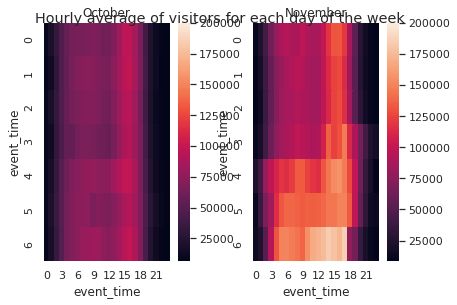

In [4]:
f.havg_visit()

# [RQ6] What's the conversion rate of your online store?


As online store we considered as usual October and November datasets; for each month we took into account the number of purchases and the number of products only viewed, since the conversion rate is defined as the ratio between these two numbers.

In [ ]:
f.conv_rate_store()

Conversion rate of online store (Oct. and Nov.) : 0.01590817944828352 




## Plot the number of purchases of each category

The plot shows once again the trend seen in Question 3 where the most preferred products are found in categories such as electronic devices and appliances.

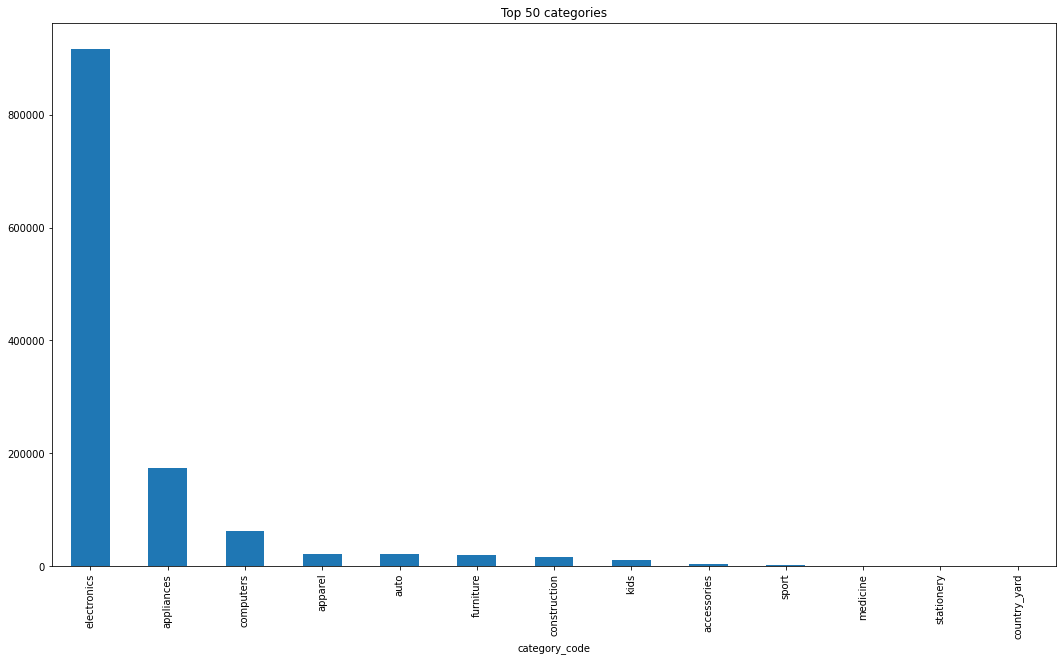

In [4]:
f.purchases_cat()

## Show the conversion rate of each category in decreasing order

In [5]:
f.cv_rate_cat()

category_code
electronics     0.024757
medicine        0.018827
stationery      0.016819
appliances      0.013555
computers       0.009897
auto            0.009890
construction    0.009376
kids            0.009015
sport           0.006565
accessories     0.006068
furniture       0.006022
apparel         0.004962
country_yard    0.004223
dtype: float64


# [RQ7] Prove that the Pareto principle applies to your store *

According to the Pareto principle, around 80% of the business of the e-commerce platform comes from about 20% of the customers. The keypoint in this task is state a definition of the "platform business". We gave two definitions of it:

1. the total profit coming from the purchases.
2. the number of operations performed within the platform.

While the first case is self-explanatory, the second case needs a little explanation. We considered that the business of an e-commerce platform, that is its profit, may not come only from the purchases, but also from the activities within it; actually, even *view* events may generate some profit thanks to the ads that may be present inside the e-commerce web pages or thanks to the visibility of the products, for which each brand may pay a fee.

According to the previous introduction, in the first case we consider the 20% of the users that have spent the most in the e-commerce platform and we compute the rate between the profit coming from them and the total profit.

In [ ]:
f.prove_pareto(['event_type', 'user_id', 'price'])

The 20% of the users is responsible of the 72.0% of the business.


In the second case, we just count how many operations each user performed, sorting them in descent order. Then, we compute the rate between the amount of operations performed by the 20% of the users and the total number of operations performed within the system. 

In [ ]:
f.prove_pareto_ops(['user_id'])

The 20% of the users is responsible of the 77.0% of the business.


In both cases, the Pareto principle applies to our store.